Epoch 1/100
55/55 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.5799 - loss: 0.7619 - val_accuracy: 0.8516 - val_loss: 0.5111
Epoch 2/100
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7904 - loss: 0.4990 - val_accuracy: 0.8630 - val_loss: 0.4326
Epoch 3/100
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8407 - loss: 0.4281 - val_accuracy: 0.8721 - val_loss: 0.3876
Epoch 4/100
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8440 - loss: 0.4045 - val_accuracy: 0.8607 - val_loss: 0.3655
Epoch 5/100
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8641 - loss: 0.3716 - val_accuracy: 0.8699 - val_loss: 0.3556
Epoch 6/100
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8581 - loss: 0.3689 - val_accuracy: 0.8607 - val_loss: 0.3500
Epoch 7/100
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8594 - loss: 0.3533 - val_accuracy: 0.8607 - val_loss: 0.3508
Epoch 8/100
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8593 - loss: 0.3593 - val_accuracy: 0.8653 - v

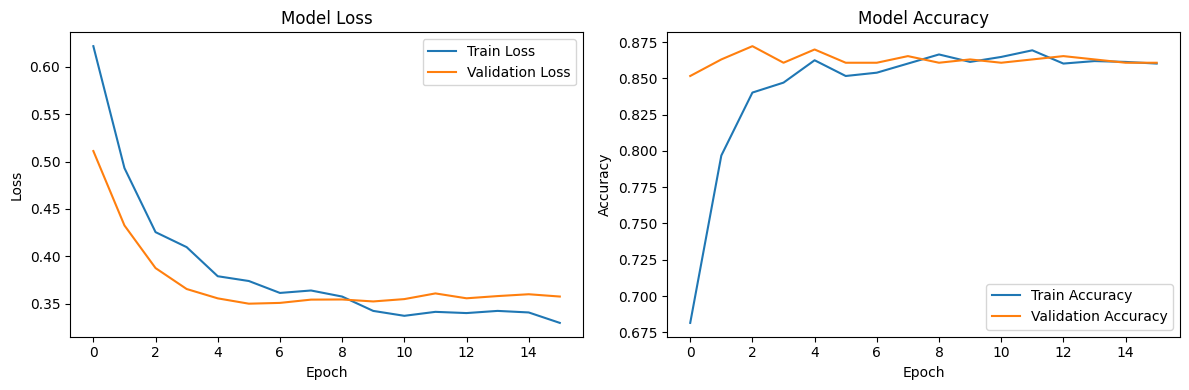

In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_auc_score
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping
import warnings
warnings.filterwarnings('ignore')

# Set random seed for reproducibility
np.random.seed(42)
tf.random.set_seed(42)

# Step 1: Load the datasets
train_df = pd.read_csv('/kaggle/input/playground-series-s5e3/train.csv')  # Replace with your train.csv file path
test_df = pd.read_csv('/kaggle/input/playground-series-s5e3/test.csv')    # Replace with your test.csv file path

# Step 2: Separate features and target from training data
X = train_df.drop(columns=['id', 'rainfall'])  # Drop 'id' and target 'rainfall'
y = train_df['rainfall']                       # Target variable
test_ids = test_df['id']                       # Save test IDs for submission
X_test = test_df.drop(columns=['id'])          # Test features

# Step 3: Handle missing values (if any)
X.fillna(X.mean(), inplace=True)               # Fill missing values with column means
X_test.fillna(X_test.mean(), inplace=True)     # Do the same for test data

# Step 4: Feature scaling (important for neural networks)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
X_test_scaled = scaler.transform(X_test)

# Step 5: Split the training data into train and validation sets
X_train, X_val, y_train, y_val = train_test_split(X_scaled, y, test_size=0.2, random_state=42, stratify=y)

# Step 6: Build the neural network model
model = Sequential([
    # Input layer
    Dense(128, activation='relu', input_shape=(X_train.shape[1],)),
    BatchNormalization(),
    Dropout(0.3),  # Dropout to prevent overfitting
    
    # Hidden layer 1
    Dense(64, activation='relu'),
    BatchNormalization(),
    Dropout(0.3),
    
    # Hidden layer 2
    Dense(32, activation='relu'),
    BatchNormalization(),
    Dropout(0.2),
    
    # Output layer (sigmoid for binary classification probabilities)
    Dense(1, activation='sigmoid')
])

# Step 7: Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Step 8: Define early stopping to prevent overfitting
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Step 9: Train the model
history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=100,
    batch_size=32,
    callbacks=[early_stopping],
    verbose=1
)

# Step 10: Evaluate the model on validation set (using ROC AUC)
y_val_pred = model.predict(X_val)
val_roc_auc = roc_auc_score(y_val, y_val_pred)
print(f"Validation ROC AUC: {val_roc_auc:.4f}")

# Step 11: Make predictions on the test set
test_pred = model.predict(X_test_scaled)

# Step 12: Prepare the submission file
submission = pd.DataFrame({'id': test_ids, 'rainfall': test_pred.flatten()})
submission.to_csv('submission.csv', index=False)
print("Submission file created: submission.csv")

# Step 13: (Optional) Plot training history
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 4))

# Plot training & validation loss
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Plot training & validation accuracy
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()